In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits
from matplotlib import colors
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from ellipse import LsqEllipse

In [2]:
alma_fits = fits.open('member.uid___A001_X340_X1d5._RXJ1842.9-3532__sci.spw17_19_21_23.cont.I.pbcor.fits')
alma_hdu = alma_fits[0]
alma_hdu.header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 / Floating point (32 bit)                        
NAXIS   =                    4                                                  
NAXIS1  =                 1000                                                  
NAXIS2  =                 1000                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    F                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   5.383532080385E-05                                                  
BMIN    =   3.920394513342E-05                                                  
BPA     =   8.972510528564E+

In [3]:
alma_data = alma_hdu.data
alma_image = alma_data[0, 0, :, :]

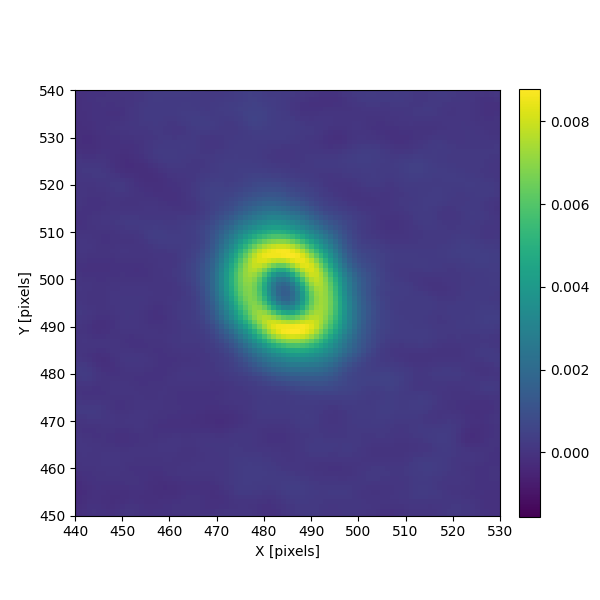

In [4]:
plt.figure(figsize=(6,6))
plt.imshow(alma_image, origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlim(440, 530)
plt.ylim(450, 540)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

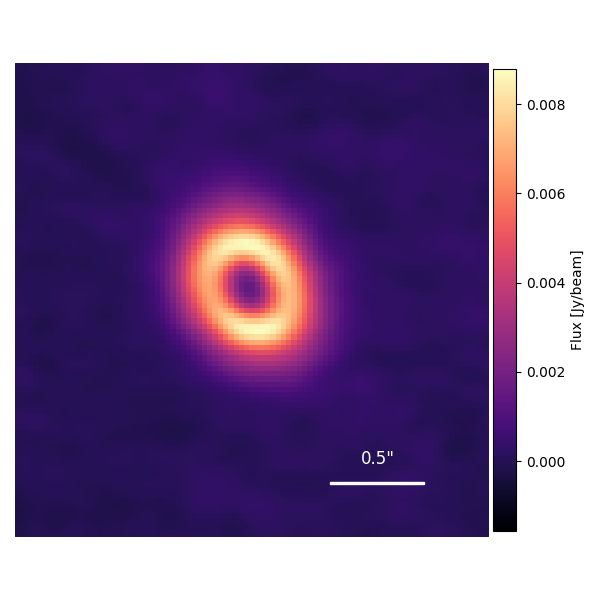

In [5]:
# Add a white 100 mas scale bar (adjust position as needed)
scale_bar_length = 17.86  # mas
scale_bar_height = 0.3    # mas (thickness of the bar)
scale_bar_x = 500       # x-position (mas)
scale_bar_y = 460       # y-position (mas)

# Create a white rectangle
scale_bar = patches.Rectangle(
    (scale_bar_x, scale_bar_y),   # (x, y) position
    scale_bar_length,             # width (mas)
    scale_bar_height,             # height (mas)
    linewidth=1, edgecolor='white', facecolor='white'
)

plt.figure(figsize=(6, 6))
plt.imshow(alma_image, origin='lower', cmap='magma')
plt.colorbar(fraction=0.046, pad=0.01, label=r"Flux [Jy/beam]")
plt.gca().add_patch(scale_bar)

# Optional: Add text label (e.g., "100 mas")
plt.text(
    scale_bar_x + scale_bar_length / 2,  # x-center of the bar
    scale_bar_y + 3,                   # y-position above the bar
"0.5\"", 
    color='white', 
    ha='center', 
    va='bottom',
    size=12
)

plt.axis('off')
plt.xlim(440, 530)
plt.ylim(450, 540)
plt.tight_layout()
plt.show()

Now, we have to **derotate** the image. To do it, we firstly have to calculate the **position angle (PA)** and the **inclination (i)**:

/tmp/ipykernel_46094/232988023.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for contour in contours.collections:


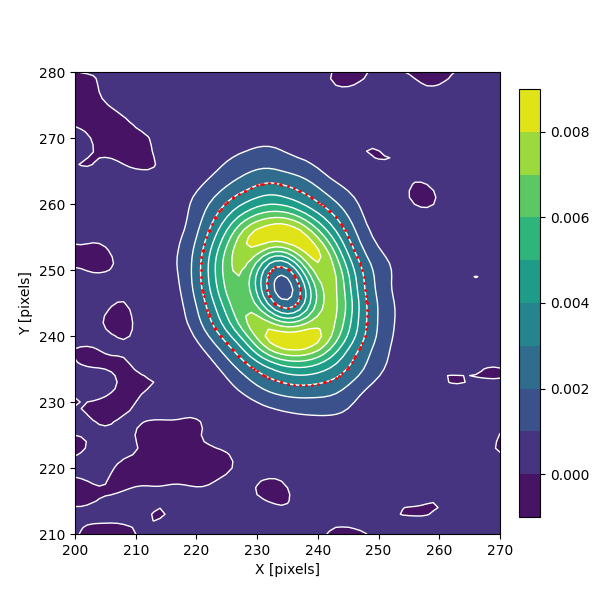

In [6]:
mask = np.ones([500, 500])
ylen, xlen = np.shape(mask)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

alma_image_cut = alma_image[250:750, 250:750]

levels = 10
contours = plt.contour(X, Y, alma_image_cut, levels=levels)

plt.figure(figsize=(6,6))
plt.contourf(alma_image_cut, levels=levels)
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(alma_image_cut, colors='white', linewidths=1, levels=levels)

all_vertices = []
for contour in contours.collections:
    for path in contour.get_paths():
        vertices = path.vertices
        # Store the vertices array in the list
        all_vertices.append(vertices)
        # Plot the points (your original code)
        #plt.scatter(vertices[:, 0], vertices[:, 1], color='red', s=1, zorder=3)

plt.scatter(all_vertices[3][:, 0], all_vertices[3][:, 1], color='red', s=1, zorder=3)
plt.xlim(200, 270)
plt.ylim(210, 280)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

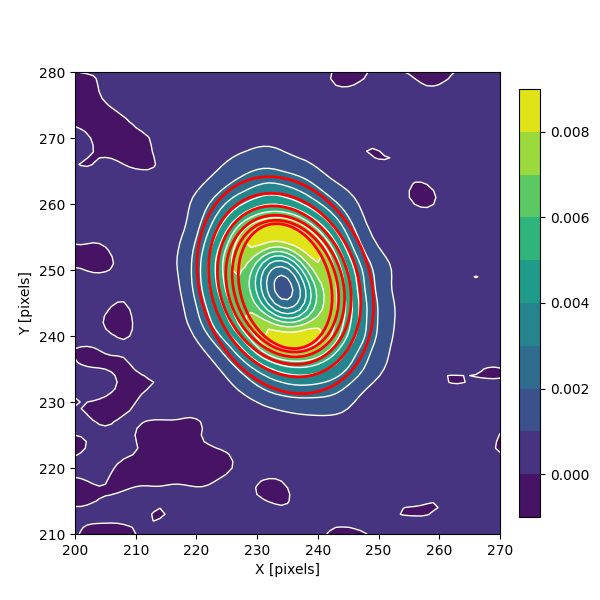

In [7]:
plt.figure(figsize=(6,6))
plt.contourf(alma_image_cut, levels=levels)
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(alma_image_cut, colors='white', linewidths=1, levels=levels)

for i in range(2, 8):
    reg = LsqEllipse().fit(all_vertices[i])
    center, width, height, phi = reg.as_parameters()
    ellipse = Ellipse(
        xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
        edgecolor='r', fc='None', lw=2, label='Fit', zorder=2
    )
    plt.gca().add_patch(ellipse)

plt.xlim(200, 270)
plt.ylim(210, 280)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

In [8]:
PA = []
I = []
for i in range(2, 8):
    reg = LsqEllipse().fit(all_vertices[i])
    center, width, height, phi = reg.as_parameters()
    ang = np.rad2deg(phi)
    inclin = np.rad2deg(np.arccos(width/height))
    PA.append(ang)
    I.append(inclin)
    
pos_angle = np.average(PA)
pos_angle_error = np.std(PA)

i_angle = np.average(I)
i_angle_error = np.std(I)

print(PA)
print(I)
print ('PA =', pos_angle, '+/-', pos_angle_error, 'degrees')
print ('i =', i_angle, '+/-', i_angle_error, 'degrees')

[27.98886232605191, 29.86814090915559, 31.497762665508727, 30.66691718288165, 26.77760452162029, 21.125358046793625]
[36.760526858984335, 35.513651138806125, 34.387408182077415, 34.43158257681219, 36.580654651071825, 40.74251549513397]
PA = 27.987440942001967 +/- 3.4542454974407772 degrees
i = 36.40272315048097 +/- 2.1498379525136437 degrees


Final result:

**PA = 28.0 $\pm$ 3.4 deg**

**i = 36.4 $\pm$ 2.1 deg**

And now we can make the **derotation**:

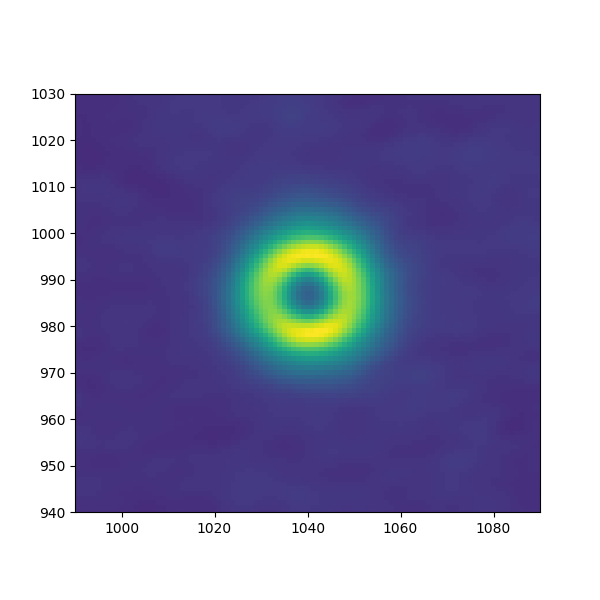

In [9]:
from skimage.transform import rotate, rescale

def deproject_disk(image, inc_deg, pa_astro_deg):
    """
    Deproject an inclined disk (PA: North-to-West).
    
    Parameters:
        image: 2D array (input image)
        inc_deg: inclination angle (0°=face-on, 90°=edge-on)
        pa_astro_deg: position angle (North-to-West) in degrees
    Returns:
        Deprojected image (face-on)
    """
    # Convert PA from North-to-West to standard mathematical convention
    pa_math_deg = 90 - pa_astro_deg
    
    # Step 1: Rotate to align major axis with x-axis
    rotated = rotate(image, -pa_math_deg, resize=True, mode='edge')
    
    # Step 2: Stretch y-axis by 1/cos(i)
    scale_y = 1 / np.cos(np.radians(inc_deg))
    deprojected = rescale(rotated, (scale_y, 1), mode='edge', anti_aliasing=True)

    # Step 3: Rotate back to original PA
    deprojected = rotate(deprojected, pa_math_deg, resize=True, mode='edge')
    
    return deprojected

little = alma_image.byteswap().newbyteorder() # converting the image to little-endian type order
alma_image_d = deproject_disk(little, 36.4, 28.0) # we put the position angle and the inclination we found with ALMA data

# Let us see the deprojeccted disk image:
plt.figure(figsize=(6, 6))
plt.imshow(alma_image_d, origin='lower')
plt.ylim(940, 1030)
plt.xlim(990, 1090)
plt.show()

In [10]:
from matplotlib.patches import Polygon

def rotated_rectangle(x_base, y_base, width, height, angle_deg=0):
    """
    Generate vertices of a rotated rectangle centered at the midpoint of its base.
    
    Parameters:
    - x_base, y_base: Midpoint of the base before rotation.
    - width, height: Dimensions of the rectangle.
    - angle_deg: Rotation angle in degrees (counter-clockwise).
    
    Returns:
    - vertices: 4x2 array of rotated rectangle vertices.
    """
    angle_rad = np.deg2rad(angle_deg)
    
    # Unrotated vertices (anchored at midpoint of base)
    half_width = width / 2
    vertices = np.array([
        [-half_width, 0],      # Bottom-left
        [half_width, 0],       # Bottom-right
        [half_width, height],  # Top-right
        [-half_width, height]  # Top-left
    ])
    
    # Rotation matrix
    rot_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    # Rotate and translate vertices
    rotated_vertices = np.dot(vertices, rot_matrix.T) + np.array([x_base, y_base])
    
    return rotated_vertices

def calculate_flux_in_rotated_rectangle(image, vertices):
    """
    Calculate flux inside a rotated rectangle defined by its vertices.
    
    Parameters:
    - image: 2D numpy array (image data).
    - vertices: 4x2 array of rectangle vertices.
    
    Returns:
    - Total flux inside the polygon.
    - Mask of the polygon (for visualization).
    """
    from matplotlib.path import Path
    
    # Create a meshgrid of pixel coordinates
    y_pixels, x_pixels = np.indices(image.shape)
    pixel_coords = np.column_stack((x_pixels.ravel(), y_pixels.ravel()))
    
    # Create a Path for the rotated rectangle
    rect_path = Path(vertices)
    
    # Check which pixels are inside the path
    mask = rect_path.contains_points(pixel_coords).reshape(image.shape)
    
    # Calculate total flux
    flux = np.sum(image[mask])
    
    return flux, mask

In [11]:
angle = np.zeros(360)
flux = np.zeros(360)
x_center, y_center = 1040, 987

for i in range (0, 360):
    rect = rotated_rectangle(x_center, y_center, 3, 30, angle_deg=i)
    angle[i] = i
    
    f, mask = calculate_flux_in_rotated_rectangle(alma_image_d, rect)
    flux[i] = f

max_flux = np.amax(flux)
norm_flux = flux/max_flux

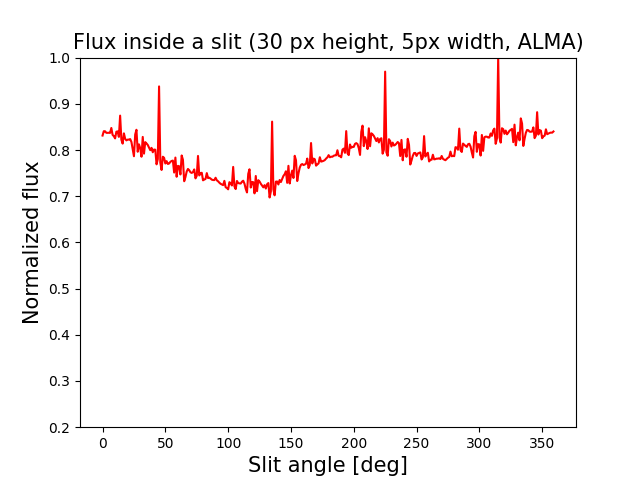

In [12]:
plt.figure()
plt.title('Flux inside a slit (30 px height, 5px width, ALMA)', fontsize=15)
plt.plot(angle, norm_flux, 'r')
plt.ylabel('Normalized flux', fontsize=15)
plt.xlabel('Slit angle [deg]', fontsize=15)
plt.ylim(0.2, 1)
plt.show()

In [13]:
from matplotlib.patches import Rectangle

def make_bordered_rectangle(x_base, y_base, width, height, thickness=0.5, label='', color='w', alpha=1.):
    """
    Draws a rectangle with only a border (transparent inside), positioned at the midpoint of its base.
    
    Parameters:
    - x_base, y_base: Coordinates of the midpoint of the base.
    - width, height: Dimensions of the rectangle.
    - thickness: Thickness of the border.
    - label: Label for legend (optional).
    - color: Border color (default: white).
    - alpha: Transparency (default: 1).
    """
    # Calculate bottom-left corner coordinates (since Rectangle uses this)
    bottom_left_x = x_base - width / 2
    bottom_left_y = y_base  # Base starts at y_base, extends upwards

    # Create the rectangle patch (only border, no fill)
    rect = Rectangle(
        (bottom_left_x, bottom_left_y),
        width, height,
        linewidth=thickness,
        edgecolor=color,
        facecolor='none',  # Transparent inside
        alpha=alpha,
        label=label
    )

    # Add to the current axis
    plt.gca().add_patch(rect)

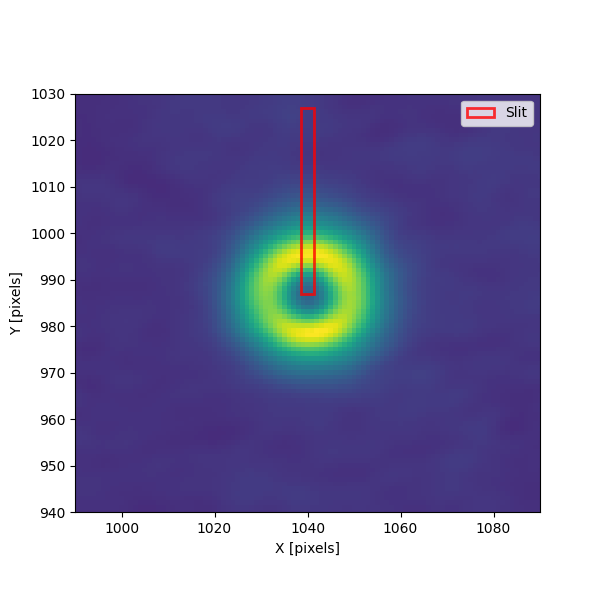

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(alma_image_d, origin='lower')
make_bordered_rectangle(
    x_base=x_center, y_base=y_center, 
    width=3, height=40, 
    thickness=2.0,  # Thicker border
    color='red', 
    alpha=0.8,
    label='Slit'
)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.legend(loc='best')
plt.ylim(940, 1030)
plt.xlim(990, 1090)
plt.show()

We see that there are some peaks, which probably are due to 'burned pixels'. We can **exlcude** them, in order to calculate the **peak in luminosity** through a **Gaussian fit**:

In [15]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def gaussian(x, amplitude, mean, stddev):
    """Gaussian function for fitting."""
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def mask_peaks(signal, height_threshold, distance=10):
    """Finds peaks and returns a mask (True where no peaks are)."""
    peaks, _ = find_peaks(signal, height=height_threshold, distance=distance) # 'distance' is the minimum distance between two adjacent peaks
    mask = np.ones_like(signal, dtype=bool)
    mask[peaks] = False  # Exclude peaks from fit
    return mask

def fit_gaussian_excluding_peaks(x, y, height_threshold):
    """Fits a Gaussian while excluding peaks."""
    mask = mask_peaks(y, height_threshold)
    x_fit = x[mask]
    y_fit = y[mask]
    
    # Initial guess for Gaussian parameters
    mean_guess = np.mean(x_fit)
    std_guess = np.std(x_fit)
    amplitude_guess = np.max(y_fit)
    
    # Fit Gaussian
    popt, pcov = curve_fit(gaussian, x_fit, y_fit, 
                          p0=[amplitude_guess, mean_guess, std_guess])
    
    return popt, pcov  # Optimal parameters and covariance

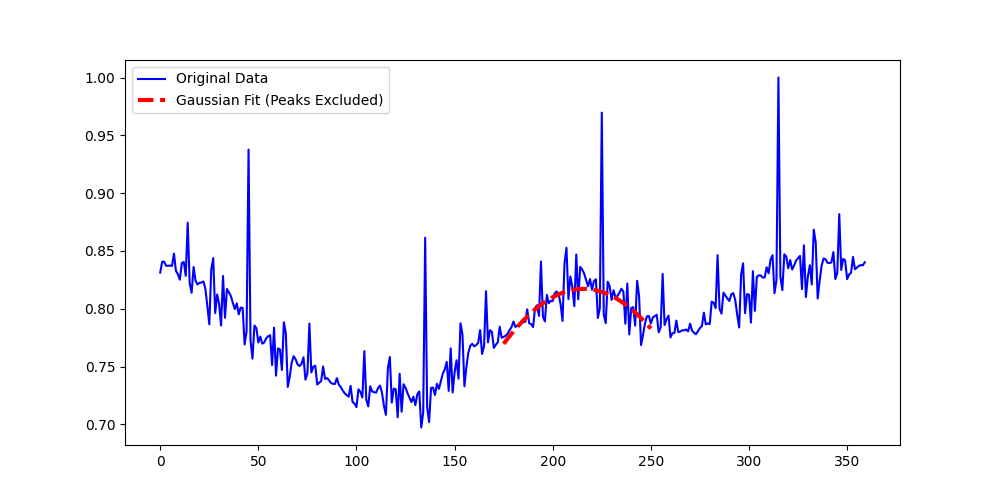

In [16]:
# Fit Gaussian while excluding peaks
height_threshold = 0.05  # Adjust based on your data

# Selecting only the luminosity peak that interests us:
mask = (angle >= 175) & (angle <= 250)
angle_masked = angle[mask]
norm_flux_masked = norm_flux[mask]
popt, pcov = fit_gaussian_excluding_peaks(angle_masked, norm_flux_masked, height_threshold)

# Reconstruct the fitted Gaussian
norm_flux_fit = gaussian(angle_masked, *popt)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(angle, norm_flux, 'b-', label="Original Data")
plt.plot(angle_masked, norm_flux_fit, 'r--', linewidth=3, label="Gaussian Fit (Peaks Excluded)")
plt.legend()
plt.show()

In [17]:
perr = np.sqrt(np.diag(pcov))

print ('fitted parameters:', popt)
print ('errors on the fitted parameters:', perr)
print ('final peak angle value:', popt[1], f'\u00B1', perr[1])

fitted parameters: [  0.81714014 215.61723686 117.36363141]
errors on the fitted parameters: [2.11985504e-03 1.17449629e+00 6.67851895e+00]
final peak angle value: 215.61723686091437 ± 1.1744962926780325


So, the final result for our peak is **215.6 $\pm$ 1.2** deg.